
## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [100]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2020-11-10 22:08:35--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘www.dropbox.com’


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [6]:
#1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' #dataset. Choose N to be smaller than or equal to the maximum number #of rows and larger that 10k.

import pandas as pd
import numpy as np
df = pd.read_csv("~/data/data_000637.txt").head(np.random.randint(10000,1310720))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
909718,1,0,64,3869208422,591,8
909719,1,1,139,3869208422,601,0
909720,1,1,2,3869208422,597,7
909721,1,0,64,3869208422,600,16


In [102]:
#2. Find out the number of BX in a ORBIT (the value 'x').
print(f"x: {df.max().BX_COUNTER-df.min().BX_COUNTER}+1 ")

x: 3563+1 


In [103]:
#3. Find out how much the data taking lasted. You can either make an 
#estimate based on the fraction of the measurements (rows) you read, 
#or perform this check precisely by reading out the whole dataset.
print(f"Time ~=  {(df['ORBIT_CNT'].max()-df['ORBIT_CNT'].min())*3564.*(25e-9)*1310720./df.shape[0]}")
print("Reading full dataset, time = 0.9804563999999999s")


Time ~=  1.1824959751464474
Reading full dataset, time = 0.9804563999999999s


In [114]:
#4. Create a new column with the absolute time in ns (as a combination
#  of the other three columns with timing information).
minOrbit = df["ORBIT_CNT"].min()
df['Timestamp'] = ((df["ORBIT_CNT"]-minOrbit)*3564*25+df['BX_COUNTER']*25+df['TDC_MEAS']*5/6)*1e-9
df 

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Timestamp
0,0,0,123,3869200167,2374,26,0.000059
1,0,0,124,3869200167,2374,27,0.000059
2,0,0,63,3869200167,2553,28,0.000064
3,1,0,64,3869200167,2558,19,0.000064
4,1,0,64,3869200167,2760,25,0.000069
...,...,...,...,...,...,...,...
593552,0,0,61,3869206176,3536,12,0.535490
593553,0,0,56,3869206176,3533,23,0.535490
593554,1,1,6,3869206176,3533,14,0.535490
593555,1,0,58,3869206176,3531,3,0.535490


In [115]:
#5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.
df['HEAD']=np.random.randint(0,2,df.shape[0])
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Timestamp
0,0,0,123,3869200167,2374,26,0.000059
1,1,0,124,3869200167,2374,27,0.000059
2,1,0,63,3869200167,2553,28,0.000064
3,0,0,64,3869200167,2558,19,0.000064
4,0,0,64,3869200167,2760,25,0.000069
...,...,...,...,...,...,...,...
593552,0,0,61,3869206176,3536,12,0.535490
593553,0,0,56,3869206176,3533,23,0.535490
593554,1,1,6,3869206176,3533,14,0.535490
593555,1,0,58,3869206176,3531,3,0.535490


In [106]:
#6\. Create a new DataFrame that contains only the rows with HEAD=1.
gdf=df[df["HEAD"] == 1]
gdf

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Timestamp
3,1,0,64,3869200167,2558,19,0.000064
4,1,0,64,3869200167,2760,25,0.000069
5,1,0,63,3869200167,2762,4,0.000069
6,1,0,61,3869200167,2772,14,0.000069
8,1,0,62,3869200167,2774,21,0.000069
...,...,...,...,...,...,...,...
593542,1,1,4,3869206176,3526,0,0.535490
593546,1,0,63,3869206176,3524,16,0.535490
593554,1,1,6,3869206176,3533,14,0.535490
593555,1,0,58,3869206176,3531,3,0.535490


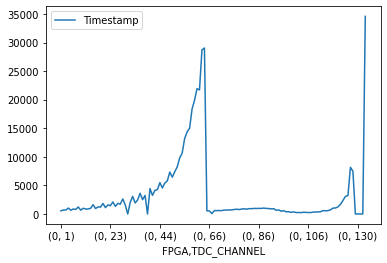

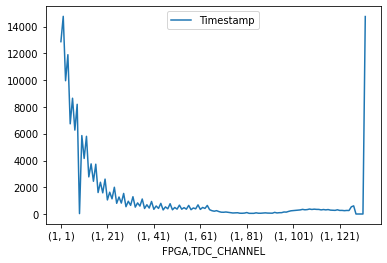

In [107]:
#7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel
import matplotlib.pyplot as plt

df[df["FPGA"]==0].groupby(["FPGA", "TDC_CHANNEL"]).Timestamp.count().plot()
plt.legend(loc='best')
plt.show()
df[df["FPGA"]==1].groupby(["FPGA", "TDC_CHANNEL"]).Timestamp.count().plot()
plt.legend(loc='best')
plt.show()

In [108]:
#8. Use the groupby method to find out the noisy channels, i.e. the 
# TDC channels with most counts (say the top 3)

df.groupby(["FPGA", "TDC_CHANNEL"])["Timestamp"].count().sort_values( ascending = False).head(15)

FPGA  TDC_CHANNEL
0     139            34583
      64             29041
      63             28720
      61             21937
      62             21710
      60             19899
      59             18382
      58             14999
1     2              14760
      139            14745
0     57             14379
      56             13201
1     1              12871
      4              11899
0     54             10654
Name: Timestamp, dtype: int64

In [5]:
#9. Count the number of unique orbits. Count the number of unique
#  orbits with at least one measurement from TDC_CHANNEL=139

print(f"Orbit count: {df['ORBIT_CNT'].nunique()}")
print(f"Orbit count with channel 139: {df[df['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique()}")

Orbit count: 11001
Orbit count with channel 139: 10976
